In [66]:
%matplotlib inline
from imports import *
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
order = ['node','Python','Ruby']
d = {'python':'Python','ruby':'Ruby'}
import effect_size
from tqdm.notebook import tqdm

## Load installed packages

In [25]:
packages = pd.read_csv('../data/cleaned_installed_packages.csv')
packages.package.fillna('nan', inplace=True)
packages['last_updated'] = pd.to_datetime(packages['last_updated'])
packages.rename(columns = {'operating':'os'}, inplace=True)
len(packages)

998727

In [26]:
npm = pd.read_csv('../data/npm_versions.csv', dtype=str)
python = pd.read_csv('../data/pypi_versions.csv', dtype=str)
ruby = pd.read_csv('../data/ruby_versions.csv', dtype=str)
available = pd.concat([npm, python, ruby])
available.package.fillna('nan', inplace=True)

packages = packages[packages.package.isin(available.package)]

In [27]:
# Filter on 3000 images
candidates_3000 = pd.read_csv('../data/considered_3000_images.csv')
mask = packages.image.isin(candidates_3000.image)
packages = packages[mask]
packages['base'] = packages['base'].replace(d)
len(packages)

816151

#### Some packages come with the base images, let's remove them!

In [28]:
# Remove duplicates and remove core packages
packages.drop_duplicates(inplace=True)
added_package = packages.query('core == False')

## Analysis

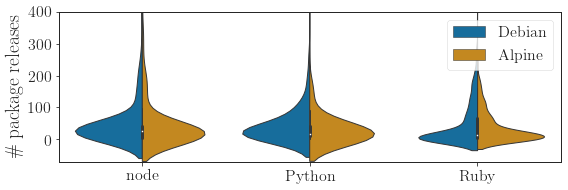

In [65]:
df_tmp = (added_package
          .groupby(['image','base','os'])
          .count()[['package']]
          .reset_index()
         )
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.76)
ax = sns.violinplot(x="base", 
                 y="package",
                   hue='os',
                 order = order,
                 data=df_tmp, 
                 linewidth=1,
                    split=True,
                  )
ax.set(
    xlabel='',
    ylabel='\# package releases',
    ylim=(-70,401)
)

ax.legend(loc='upper right')
plt.yticks(pd.np.arange(0, 401, 100)) 


In [30]:
print(df_tmp.groupby(['base'])['package'].describe().drop(['std','count','25%', '75%'], axis=1).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &       mean &  min &   50\% &    max \\
base   &            &      &       &        \\
\midrule
Python &  45.208000 &  1.0 &  17.0 &  939.0 \\
Ruby   &  44.612613 &  1.0 &  15.0 &  377.0 \\
node   &  58.642320 &  1.0 &  26.0 &  943.0 \\
\bottomrule
\end{tabular}



In [31]:
df_tmp.groupby(['base'])['package'].describe()

,count,mean,std,min,25%,50%,75%,max
base,,,,,,,,
Python,1000.0,45.208000,109.719210,1.0,9.0,17.0,42.0,939.0
Ruby,999.0,44.612613,61.754306,1.0,3.0,15.0,67.0,377.0
node,931.0,58.642320,111.290224,1.0,5.0,26.0,43.0,943.0


In [32]:
if False:
    df_tmp = (added_package
          [['image','base','os','package']]
          .drop_duplicates()
          .groupby(['image','base','os'])
          .count()[['package']]
          .reset_index()
         )
    df_tmp.groupby(['base'])['package'].describe()

In [33]:
df_tmp.groupby(['base','os'])['package'].describe()

count       mean         std  min    25%   50%    75%    max
base   os                                                                  
Python Alpine  446.0  40.591928  118.647923  1.0   7.25  12.0  31.00  939.0
       Debian  554.0  48.924188  101.922752  1.0  11.00  22.0  52.00  916.0
Ruby   Alpine  251.0  37.175299   47.295509  1.0   3.00  15.0  57.50  238.0
       Debian  748.0  47.108289   65.738603  1.0   2.00  14.0  73.25  377.0
node   Alpine  365.0  55.457534  114.632003  1.0   5.00  24.0  38.00  894.0
       Debian  566.0  60.696113  109.134144  1.0   5.00  29.0  51.00  943.0

In [34]:
# Mann-whitney u test
for base in [['node','Ruby'], ['node','Python'], ['Python','Ruby']]:
    print(base,scipy.stats.mannwhitneyu(df_tmp.query('base =="'+base[0]+'"').package,
                                        df_tmp.query('base =="'+base[1]+'"').package))

['node', 'Ruby'] MannwhitneyuResult(statistic=375521.5, pvalue=1.1504837921374184e-13)
['node', 'Python'] MannwhitneyuResult(statistic=433419.5, pvalue=0.004351596387186694)
['Python', 'Ruby'] MannwhitneyuResult(statistic=437663.5, pvalue=8.086881569433275e-07)


In [35]:
# Effect size
for base in [['node','Ruby'], ['node','Python'], ['Python','Ruby']]:
    print(base,effect_size.cliffsDelta(df_tmp.query('base =="'+base[0]+'"').package,
                                        df_tmp.query('base =="'+base[1]+'"').package))

d=0.19248679399055338
['node', 'Ruby'] True
d=0.06891621911922664
['node', 'Python'] False
d=0.1237967967967968
['Python', 'Ruby'] False


In [36]:
# Distribution of those CORE packages
(packages
 .query('core == True')
 .groupby(['image','base','os'])
 .count()[['package']]
 .reset_index()
 .groupby(['base','os'])['package'].describe())

count        mean        std    min    25%    50%     75%    max
base os                                                                      
Ruby Alpine  252.0   23.642857  13.728421    7.0   12.0   15.0   39.25   48.0
     Debian  748.0   19.847594  12.313542    5.0   11.0   13.0   30.00   55.0
node Alpine  403.0  343.451613  74.185189   68.0  333.0  372.0  383.00  574.0
     Debian  597.0  301.504188  93.843233  121.0  191.0  342.0  372.00  512.0

In [37]:
Set1 = sns.color_palette('Set1', n_colors=12)

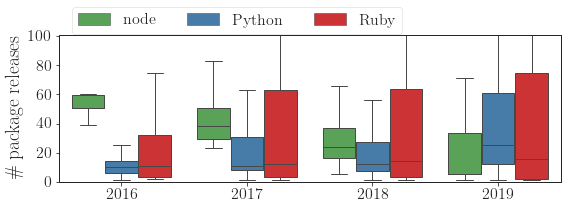

In [63]:
# without core packages, by year
df_tmp = (added_package
          .groupby(['image','base','last_updated','os'])
          .count()[['package']]
          .reset_index()
         )
df_tmp['year'] = df_tmp['last_updated'].apply(lambda x: x.year)
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxplot(x="year", 
                 y="package",
                   hue='base',
                 hue_order = order,
                 data=df_tmp, 
                 palette=reversed(Set1),
                 linewidth=1,
                 showfliers= False
                  )
ax.set(
    xlabel='',
    ylabel='\# package releases',
    ylim=(0,101)
)
ax.legend(bbox_to_anchor= (0.7, 0.95), ncol=3)
plt.yticks(pd.np.arange(0, 101, 20)) 

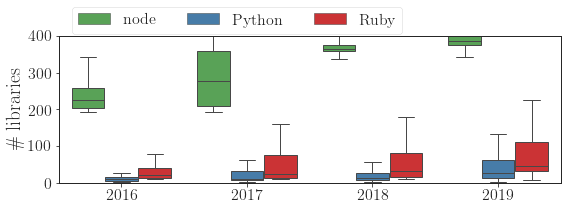

In [60]:
# without core packages, by year
df_tmp = (packages
          .groupby(['image','base','last_updated','os'])
          .count()[['package']]
          .reset_index()
         )
df_tmp['year'] = df_tmp['last_updated'].apply(lambda x: x.year)
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxplot(x="year", 
                 y="package",
                   hue='base',
                 hue_order = order,
                 data=df_tmp, 
                 palette=reversed(Set1),
                 linewidth=1,
                 showfliers= False
                  )
ax.set(
    xlabel='',
    ylabel='\# libraries',
    ylim=(0,401)
)
#ax.set_yscale('log')
ax.legend(bbox_to_anchor= (0.7, 0.96), ncol=3)
plt.yticks(pd.np.arange(0, 401, 100)) 

In [192]:
df_tmp.groupby(['base','year'])['package'].describe()

count       mean         std   min    25%   50%    75%    max
base   year                                                               
Python 2016   40.0  13.375000   14.391393   1.0   5.75  10.0  14.25   76.0
       2017  129.0  23.085271   25.666135   1.0   8.00  11.0  31.00  112.0
       2018  297.0  25.481481   36.453513   1.0   7.00  12.0  27.00  249.0
       2019  534.0  63.908240  144.534879   1.0  12.00  25.0  60.75  939.0
Ruby   2016   35.0  29.028571   40.128093   2.0   3.00  11.0  32.00  147.0
       2017  178.0  41.938202   56.038441   1.0   3.00  12.0  62.75  271.0
       2018  330.0  41.003030   57.004746   1.0   3.00  14.5  64.00  342.0
       2019  456.0  49.464912   67.960484   1.0   2.00  15.5  74.75  377.0
node   2016   42.0  79.261905   86.193503  38.0  51.00  51.0  59.50  556.0
       2017  202.0  79.306931  133.814957  23.0  29.00  38.0  51.00  943.0
       2018  299.0  53.568562  100.692224   5.0  16.50  24.0  37.00  894.0
       2019  388.0  49.561856  107.226312   1.0   5.00   5.0  33.25  820.0

In [195]:
(added_package[['image','package','base']]
 .drop_duplicates()
 .groupby(['base','package'])
 .count()
 .reset_index()
 .sort_values('image', ascending=False)
 .groupby(['base'])
 .head(5)
)

,base,package,image
4716,Ruby,did_you_mean,904
8861,node,fstream,903
7979,node,block-stream,902
8055,node,builtin-modules,852
9268,node,is-builtin-module,851
6429,Ruby,rubygems-update,848
10116,node,npm-registry-client,809
3360,Python,six,733
3200,Python,requests,631
3672,Python,urllib3,626


## Now check the dependency between the packages 
### (all packages are included in the dataset package_dependencies.csv)

In [6]:
deps  = pd.read_csv('../data/package_dependencies.csv')
deps = deps.query('package!=dependency')
deps['base'] = deps['base'].replace(d)
deps.drop('docker', axis=1, inplace=True)

In [8]:
packs = added_package[['image','base','package']].drop_duplicates()
taille = added_package[['image','base']].drop_duplicates()
packs.set_index('image', inplace=True)
results2 = []
for row in tqdm(added_package[['image','base']].drop_duplicates().iterrows(), total=len(taille)):
    image = row[1]['image']
    base = row[1]['base']
    list_packs = packs.loc[image].package
    
    try:
        deps_tmp = deps[deps.package.isin(list_packs)]
        deps_tmp = deps_tmp[deps_tmp.dependency.isin(list_packs)]
    except:
        deps_tmp = deps[deps.package.isin([list_packs])]
        deps_tmp = deps_tmp[deps_tmp.dependency.isin([list_packs])]
        
    deps_tmp['image'] = image
    deps_tmp['base'] = base
    
    try:
        list_packs = packs.loc[image][~packs.loc[image].package.isin(deps_tmp.package.tolist()+deps_tmp.dependency.tolist())]
        list_packs = list_packs.package.unique().tolist()
    except:
        if list_packs not in deps_tmp.package.tolist()+deps_tmp.dependency.tolist():
            list_packs = [list_packs]

    deps_tmp = deps_tmp[~deps_tmp.package.isin(deps_tmp.dependency)]
    results2.append(deps_tmp)
    
    df = pd.DataFrame({'base':base, 'package':list_packs, 'dependency':'undefined', 'image':image})
    results2.append(df)
results2 = pd.concat(results2)

In [9]:
len(results2), len(added_package)

(87130, 144372)

In [148]:
added_package.package.unique().size

11607

In [149]:
results2.package.unique().size

5495

In [11]:
(results2[['image','package','base']]
 .drop_duplicates()
 .groupby(['image','base'])
 .count()
 .reset_index()
 .groupby(['base'])['package']
 .describe()
)

,count,mean,std,min,25%,50%,75%,max
base,,,,,,,,
Python,1000.0,26.653000,81.480118,1.0,5.0,8.0,21.0,710.0
Ruby,999.0,13.039039,16.872488,1.0,2.0,4.0,18.0,101.0
node,931.0,10.823845,7.302460,1.0,4.0,9.0,15.0,45.0


In [13]:
#results2[['package','base','image']].drop_duplicates().to_csv('../data/top_packages.csv', index=False)

# Let's extract Dockerfiles of DockerHube images

In [11]:
import re
import json
import requests
from tqdm import tqdm
import pandas as pd
import multiprocessing as mp

# This script inspects an image in DockerHub and gets its Dockerfile commands with other information like the layers SHA

def download_url(url):
    ''' Download an url and returns the content'''
    
    response = requests.get(url)
    webContent  = response.json()
    return webContent

def image_metadata(url, source):
    ''' Parse a json file from url  '''
    
    names = []
    pops = []
    data  = download_url(url)
    for element in data['summaries']:
        popularity=str(element['popularity'])
        if source == "official":
            name=str(element['slug'])
        else:
            name=str(element['name'])
        names.append(name)
        pops.append(popularity)
    df = pd.DataFrame({'name': names, 'popularity': pops})
    return df


def number_images(url):
    ''' Returns the number of images returned in a query '''

    data=download_url(url)
    try:
        number = int(data['count'])
    except:
        return 0
    return number

def official_images():
    ''' Extract the names of official images  '''

    df_all = pd.DataFrame()
    url_option = 'https://store.docker.com/api/content/v1/products/search/?q=+&type=image&page='
    page = 1
    while(True):
        url = url_option + str(page) + "&page_size=100"
        try:
            df = image_metadata(url, 'official')
        except:
            break
        df_all = pd.concat([df_all,df])
        page = page + 1
    return df_all

def community_helper(string):
    ''' This is a helper to the "community_images()" function '''

    df_all = pd.DataFrame()
    url_option = 'https://store.docker.com/api/content/v1/products/search?q='
    page = 1
    while(True):
        url = url_option + string +"&source=community&type=image&page="+str(page)+"&page_size=100"
        try:
            df = image_metadata(url, 'community')
        except:
            break
        df_all = pd.concat([df_all,df])
        page = page + 1
    return df_all 


def community_images():
    ''' Extract the names of all community images  '''
    
    df_all = []
    url_option = 'https://store.docker.com/api/content/v1/products/search?q='
    options = '&source=community&type=image&page=1&page_size=100'
    stringer = 'abcdefghijklmnopqrstuvwxyz0123456789'
    stringer = 'a'
    for c1 in tqdm(stringer):
        for c2 in stringer:
            url = url_option + c1 + c2 + options
            number  = number_images(url)
            if number > 10000:
                for c3 in stringer:
                    url = url_option + c1 + c2 + c3+ options
                    df_all.append(community_helper(c1+c2+c3))
            else:
                df_all.append(community_helper(c1+c2))
    df_all = pd.concat(df_all)
    df_all.drop_duplicates(inplace=True)
    df_all = df_all.groupby(['name']).first().reset_index()
    return df_all
                           

def extract_tags(url):
    ''' Returns the tags available for a certain repository '''

    data = download_url(url)
    tags = []
    size = []
    date = []
    for result in data['results']:
        tags.append(str(result['name']))
        size.append(str(result['full_size']))
        date.append(str(result['last_updated']))
    df = pd.DataFrame({'tag': tags, 'full_size': size, 'last_updated': date})
    return df

def official_tags(name):
    ''' Returns the tags available for a certain OFFICIAL repository '''

    df_all = pd.DataFrame()
    page = 1
    while(True):
        url="https://registry.hub.docker.com/v2/repositories/library/"+str(name)+"/tags/?page="+str(page)+"&page_size=100"
        try:
            df_all = pd.concat([df_all, extract_tags(url)])
        except :
            break
        page = page +1
            
    return df_all
        

def community_tags(name):
    ''' Returns the tags available for a certain COMMUNITY repository '''

    df_all = pd.DataFrame()
    page = 1
    while(True):
        url="https://registry.hub.docker.com/v2/repositories/"+str(name)+"/tags/?page="+str(page)+"&page_size=100"
        try:
            df_all = pd.concat([df_all, extract_tags(url)])
        except:
            break
        page = page +1
    return df_all

def get_token(image,tag):
    ''' Returns the token needed to inspect the layers of a Docker image'''

    url = "https://auth.docker.io/token?scope=repository:"+str(image)+":pull&service=registry.docker.io"
    token = download_url(url)
    return token['token']


def get_manifest(image,tag,token):
    ''' Returns the manifest of an image containing layer ids '''

    headers = {'Accept': 'application/vnd.docker.distribution.manifest.v2+json',
           'Authorization': 'Bearer '+str(token)}
    url = 'https://registry-1.docker.io/v2/'+str(image)+'/manifests/'+str(tag)
    
    response = requests.get(url, headers=headers)
    return response.json()

def get_fsLayer(image,tag,token):
    ''' Returns the manifest of an image containing layer ids and their commands'''

    headers = {'Authorization': 'Bearer '+str(token)}
    url = 'https://registry-1.docker.io/v2/'+str(image)+'/manifests/'+str(tag)
    
    response = requests.get(url, headers=headers)
    return response.json()


def inspect_dict(name, tag):
    ''' Parse the manifest result and return the information needed as a dict variable'''

    token = get_token(name,tag)
    manifest = get_fsLayer(name,tag,token)
    image_layers = {}
    image_layers ['name'] = name
    image_layers ['tag'] = tag
    image_layers ['layers'] = []
    for i, blob in enumerate(manifest['fsLayers']):
        command = json.loads(manifest['history'][i]['v1Compatibility'])['container_config']['Cmd'][-1]
        command = command.replace('/bin/sh -c #(nop) ','').replace('/bin/sh -c','RUN')
        if command.lstrip().startswith('set'):
            command = 'RUN '+command
        layer = {}
        layer['blob'] = blob['blobSum'].split(':')[-1]        
        layer['order'] = len(manifest['fsLayers']) - i
        layer['created'] = json.loads(manifest['history'][i]['v1Compatibility'])['created']
        layer['command'] = command
        image_layers ['layers'].append(layer)
    
    return image_layers, token


def inspect_df(name, tag):
    ''' Parse the manifest result and return the information needed as a dataframe'''

    token = get_token(name,tag)
    manifest = get_fsLayer(name,tag,token)
    blobsums = []
    commands = []
    creation = []
    for i, blob in enumerate(manifest['fsLayers']):
        blobsums.append(blob['blobSum'].split(':')[-1])
        command = json.loads(manifest['history'][i]['v1Compatibility'])['container_config']['Cmd'][-1]
        command = command.replace('/bin/sh -c #(nop) ','').replace('/bin/sh -c','RUN')
        if command.lstrip().startswith('set'):
            command = 'RUN '+command
        commands.append(command)
        creation.append(json.loads(manifest['history'][i]['v1Compatibility'])['created'])
        
    df = pd.DataFrame({'blob':reversed(blobsums), 
                       'created':reversed(creation), 
                       'command': reversed(commands)
                      })
    return df

def inspect_image(image):
    tag = 'latest'
    try: 
        df = inspect_df(image, tag).assign(image= image)
    except: 
        df = pd.DataFrame()
    return df


In [164]:
# Create tasks
images=packages.image.unique().tolist()
len(images)

# MUlti processing
pool= mp.Pool(processes=8)
results=pool.imap_unordered(inspect_image, images, 20)

# get results
tab=[]
for df in results:
    tab.append(df)
tab = pd.concat(tab)

# Close
pool.close()
pool.join()


In [13]:
tab = []
images=packages.image.unique().tolist()
for image in tqdm(images, total=len(images)):
    df = inspect_image(image)
    tab.append(df)
tab = pd.concat(tab)


100%|██████████| 3000/3000 [30:51<00:00,  1.62it/s] 


In [14]:
tab.image.unique().size

1385

In [167]:
#tab.to_csv('../data/image_dockerfiles.csv', index=False)

In [168]:
tab2 = (tab
       .merge(packages[['image','base']].drop_duplicates(),
              on='image',
              how='left'
             )
        .dropna()
       )

In [169]:
tab2[['base','image']].drop_duplicates().groupby('base').count()

,image
base,
Python,347
Ruby,516
node,620


In [ ]:
mask = tab2.command.str.contains('pip install')
mask2 = tab2.command.str.contains('pip2 install')
mask3 = tab2.command.str.contains('pip3 install')

tab2[mask+mask2+mask2].image.unique().size

In [163]:
286/376, 551/623, 352/397

(0.7606382978723404, 0.884430176565008, 0.8866498740554156)